In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
val_dir = "../input/chest-xray-pneumonia/chest_xray/val"
print("Dataset loaded!!")

Dataset loaded!!


In [3]:
print("Train set:")
print("-"*60)
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("\nTest set:")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("\nValidation set")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir = "../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

Train set:
------------------------------------------------------------
PNEUMONIA=3875
NORMAL=1341

Test set:
------------------------------------------------------------
PNEUMONIA=390
NORMAL=234

Validation set
------------------------------------------------------------
PNEUMONIA=8
NORMAL=8


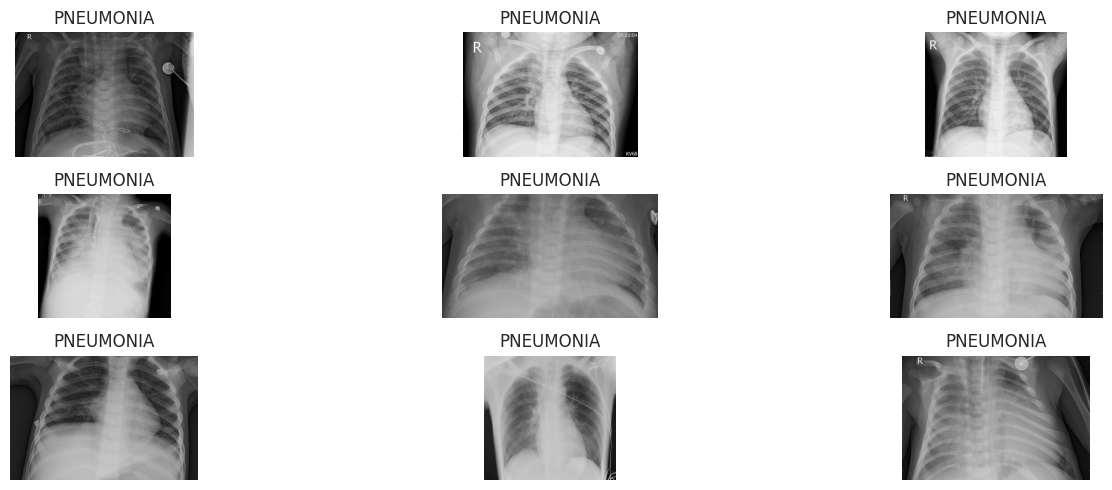

In [4]:
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("PNEUMONIA")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    

plt.tight_layout()

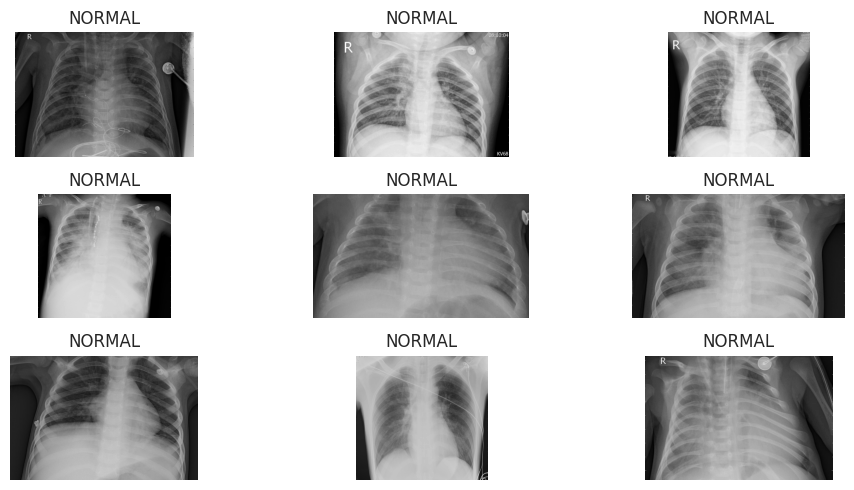

In [5]:
normal = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/NORMAL")
normal_dir = "../input/chest-xray-pneumonia/chest_xray/train/NORMAL"

plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("NORMAL")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

In [6]:
import glob

pneumonia_train = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train_dir+"/NORMAL/*.jpeg")

In [7]:
data = pd.DataFrame(np.concatenate([[0]*len(normal_train) , [1]*len(pneumonia_train)]),columns=["class"])

In [8]:
data.head()

,class
0,0
1,0
2,0
3,0
4,0


In [9]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)
train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=32,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=2,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=2,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
img, label = next(train)

In [11]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

80134624/80134624 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [13]:
history = model.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 109s 963ms/step - loss: 0.4918 - accuracy: 0.7719 - val_loss: 0.4883 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 87s 864ms/step - loss: 0.4297 - accuracy: 0.7937 - val_loss: 0.4711 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 82s 821ms/step - loss: 0.3915 - accuracy: 0.8188 - val_loss: 0.4826 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 78s 774ms/step - loss: 0.3779 - accuracy: 0.8266 - val_loss: 0.4549 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 78s 776ms/step - loss: 0.3524 - accuracy: 0.8372 - val_loss: 0.4591 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 77s 769ms/step - loss: 0.3384 - accuracy: 0.8469 - val_loss: 0.4455 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/30
100/100 [==============================]

In [14]:
# Evaluating the model on train and test
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

163/163 [==============================] - 123s 750ms/step - loss: 0.2352 - accuracy: 0.8988
Train Loss:  0.23517505824565887
Train Accuracy:  0.8987730145454407


In [15]:
# Test data
score = model.evaluate(test)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

312/312 [==============================] - 9s 28ms/step - loss: 0.3228 - accuracy: 0.8782
Test Loss:  0.3227901756763458
Test Accuracy:  0.8782051205635071


Text(0.5, 1.0, 'Accuracy Evolution')

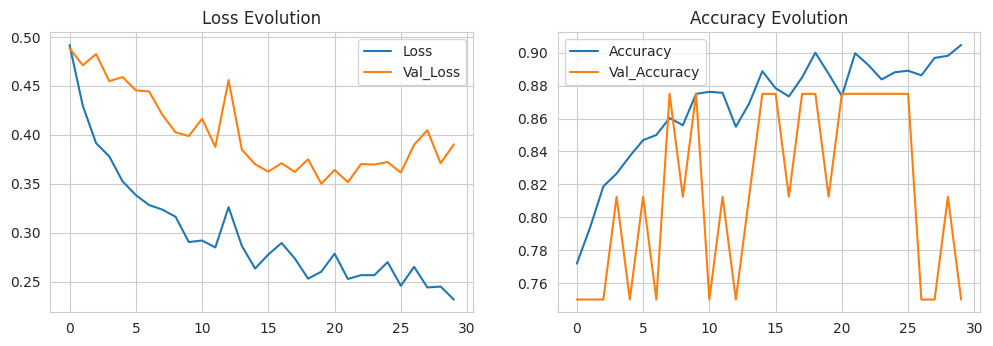

In [16]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF VGG19')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [17]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False
    
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

# to avoid overfitting
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)

# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

94668760/94668760 [==============================] - 0s 0us/step


In [18]:
history = model2.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 80s 748ms/step - loss: 0.2703 - accuracy: 0.8859 - val_loss: 0.2170 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 75s 745ms/step - loss: 0.2144 - accuracy: 0.9106 - val_loss: 0.1658 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 76s 755ms/step - loss: 0.1962 - accuracy: 0.9216 - val_loss: 0.1283 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 75s 751ms/step - loss: 0.1759 - accuracy: 0.9303 - val_loss: 0.1639 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 75s 753ms/step - loss: 0.1776 - accuracy: 0.9262 - val_loss: 0.1175 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 74s 741ms/step - loss: 0.1972 - accuracy: 0.9231 - val_loss: 0.3566 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/30
100/100 [==============================] 

In [19]:
# Evaluating the model on train and test
score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 121s 741ms/step - loss: 0.1221 - accuracy: 0.9517
Train Loss:  0.12205091118812561
Train Accuracy:  0.9516870975494385
312/312 [==============================] - 6s 20ms/step - loss: 0.2104 - accuracy: 0.9183

Test loss:  0.21036739647388458
Test Accuracy:  0.9182692170143127


Text(0.5, 1.0, 'Accuracy Evolution')

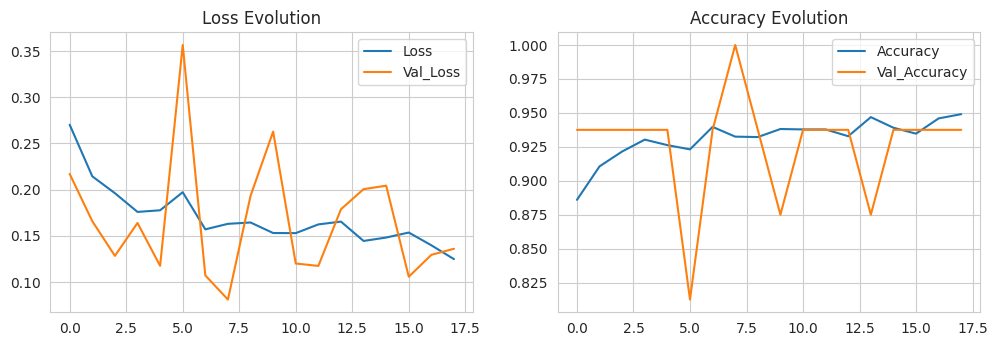

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [21]:
mobilenet_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in mobilenet_model.layers:
    layer.trainable=False
    
x = mobilenet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model3 = tf.keras.Model(inputs=mobilenet_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model3.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/30
100/100 [==============================] - 78s 742ms/step - loss: 0.3112 - accuracy: 0.8553 - val_loss: 0.4136 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 74s 739ms/step - loss: 0.2334 - accuracy: 0.9028 - val_loss: 0.2980 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 75s 751ms/step - loss: 0.2145 - accuracy: 0.9056 - val_loss: 0.3748 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 75s 747ms/step - loss: 0.1969 - accuracy: 0.9162 - val_loss: 0.1705 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 75s 747ms/step - loss: 0.2160 - accuracy: 0.9097 - val_loss: 0.1950 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 74s 740ms/step - loss: 0.1891 - accuracy: 0.9197 - val_loss: 0.2348 - val_accuracy: 0.9375 - 

In [22]:
# Evaluating the model on train and test
score = model3.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model3.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 119s 727ms/step - loss: 0.1619 - accuracy: 0.9363
Train Loss:  0.1619185209274292
Train Accuracy:  0.9363496899604797
312/312 [==============================] - 6s 19ms/step - loss: 0.2323 - accuracy: 0.9087

Test loss:  0.2323031723499298
Test Accuracy:  0.9086538553237915


Text(0.5, 1.0, 'Accuracy Evolution')

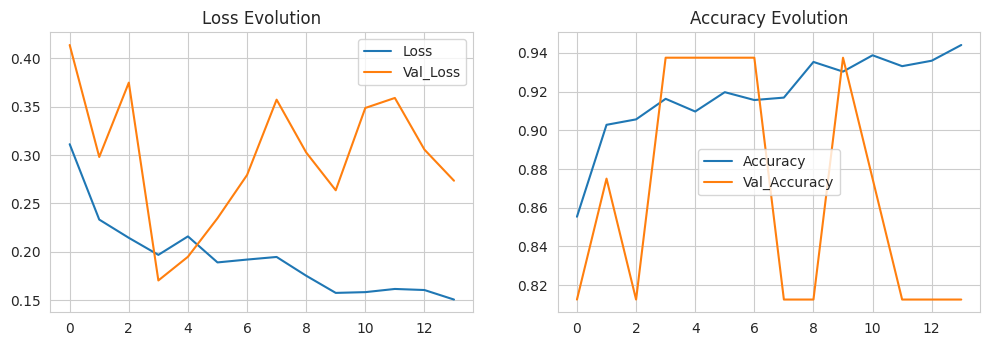

In [23]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [24]:
# Saving these 3 models
model.save('vgg19.h5')
model2.save('resnet50v2.h5')
model3.save('mobilenetv2.h5')

In [25]:
resnet_model.trainable = True
vgg_model.trainable = True
mobilenet_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(vgg_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  22


In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [28]:
# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
len(model.trainable_variables)

4

In [29]:
fine_tune_epochs = 10
epochs_on_raw_model = 30

total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model.fit(train,epochs=total_epochs, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/40
100/100 [==============================] - 76s 745ms/step - loss: 0.2508 - accuracy: 0.8944 - val_loss: 0.3804 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/40
100/100 [==============================] - 75s 747ms/step - loss: 0.2549 - accuracy: 0.8934 - val_loss: 0.4253 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/40
100/100 [==============================] - 75s 751ms/step - loss: 0.2392 - accuracy: 0.9006 - val_loss: 0.3773 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/40
100/100 [==============================] - 75s 744ms/step - loss: 0.2350 - accuracy: 0.9025 - val_loss: 0.3660 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/40
100/100 [==============================] - 76s 757ms/step - loss: 0.2398 - accuracy: 0.9025 - val_loss: 0.4735 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 6/40
100/100 [==============================] - 75s 752ms/step - loss: 0.2322 - accuracy: 0.8991 - val_loss: 0.4134 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 7/40
100/100 [==============================] 

In [30]:
# Evaluating the model on train and test
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 122s 744ms/step - loss: 0.2220 - accuracy: 0.9076
Train Loss:  0.22202526032924652
Train Accuracy:  0.9075919985771179
312/312 [==============================] - 7s 21ms/step - loss: 0.3140 - accuracy: 0.8654

Test loss:  0.3140048384666443
Test Accuracy:  0.8653846383094788


Text(0.5, 1.0, 'Accuracy Evolution')

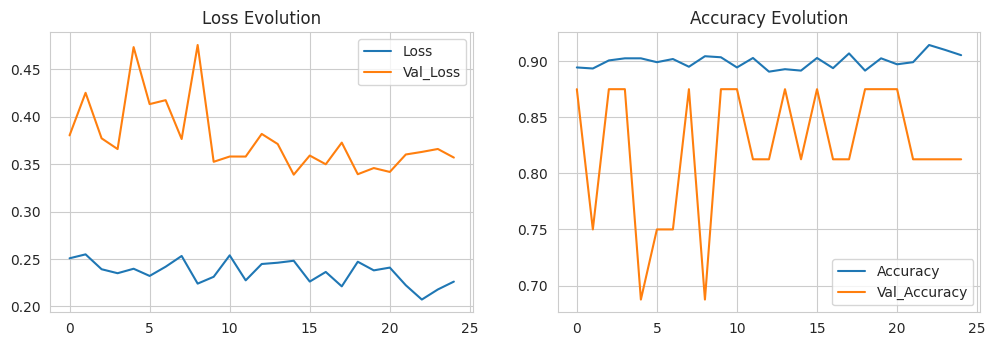

In [31]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label='Loss')
plt.plot(history_fine.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [32]:
# Fine tuning the resnet model


# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [33]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

In [34]:
# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [35]:
len(model2.trainable_variables)

86

In [36]:
fine_tune_epochs = 10
epochs_on_raw_model = 30

total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model2.fit(train,epochs=total_epochs, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/40
100/100 [==============================] - 94s 750ms/step - loss: 0.2994 - accuracy: 0.8772 - val_loss: 31.6484 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/40
100/100 [==============================] - 76s 756ms/step - loss: 0.2003 - accuracy: 0.9253 - val_loss: 0.7436 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/40
100/100 [==============================] - 74s 740ms/step - loss: 0.1640 - accuracy: 0.9388 - val_loss: 0.2992 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/40
100/100 [==============================] - 74s 735ms/step - loss: 0.1382 - accuracy: 0.9431 - val_loss: 0.2675 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/40
100/100 [==============================] - 74s 742ms/step - loss: 0.1426 - accuracy: 0.9447 - val_loss: 0.1267 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/40
100/100 [==============================] - 77s 764ms/step - loss: 0.1331 - accuracy: 0.9475 - val_loss: 0.1101 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 7/40
100/100 [==============================]

In [37]:
# Evaluating the model on train and test
score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])


163/163 [==============================] - 120s 735ms/step - loss: 0.0583 - accuracy: 0.9814
Train Loss:  0.05832060053944588
Train Accuracy:  0.9814033508300781
312/312 [==============================] - 6s 19ms/step - loss: 0.1559 - accuracy: 0.9407

Test loss:  0.1559443175792694
Test Accuracy:  0.9407051205635071


In [38]:
# Fine tuning the mobilenetv2

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mobilenet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenet_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [39]:
# Compiling the model
model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
len(model3.trainable_variables)

58

In [40]:
fine_tune_epochs = 10
epochs_on_raw_model = 30

total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model3.fit(train,epochs=total_epochs, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/40
100/100 [==============================] - 88s 762ms/step - loss: 0.2669 - accuracy: 0.8956 - val_loss: 33.5824 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/40
100/100 [==============================] - 73s 725ms/step - loss: 0.1840 - accuracy: 0.9244 - val_loss: 12.3772 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/40
100/100 [==============================] - 73s 731ms/step - loss: 0.1549 - accuracy: 0.9419 - val_loss: 11.2556 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/40
100/100 [==============================] - 74s 742ms/step - loss: 0.1449 - accuracy: 0.9422 - val_loss: 20.6126 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/40
100/100 [==============================] - 73s 729ms/step - loss: 0.1438 - accuracy: 0.9478 - val_loss: 18.6749 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/40
100/100 [==============================] - 74s 734ms/step - loss: 0.1307 - accuracy: 0.9525 - val_loss: 0.7028 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/40
100/100 [===========================

In [41]:
# Evaluating the model on train and test
score = model3.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model3.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 117s 718ms/step - loss: 0.3123 - accuracy: 0.9377
Train Loss:  0.3123222887516022
Train Accuracy:  0.9376916885375977
312/312 [==============================] - 6s 19ms/step - loss: 1.8999 - accuracy: 0.8045

Test loss:  1.8999242782592773
Test Accuracy:  0.8044871687889099


Text(0.5, 1.0, 'Accuracy Evolution')

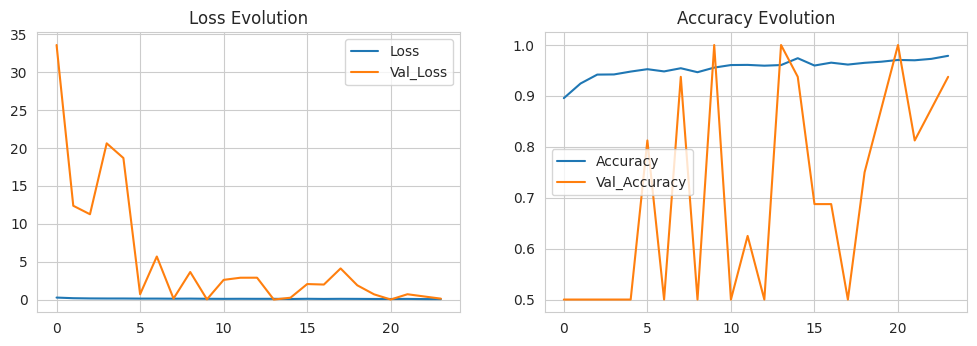

In [42]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label='Loss')
plt.plot(history_fine.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [43]:
# Saving the fine tuned model
model.save('tuned_vgg19.h5')
model2.save('tuned_resnet.h5')
model3.save('tuned_mobilenet.h5')

In [44]:
# Loading the saved version of Tuned-ResNet50V2
final_model = tf.keras.models.load_model('tuned_resnet.h5')
y_pred = final_model.predict(test)
final_model.evaluate(test)

312/312 [==============================] - 7s 18ms/step - loss: 0.1559 - accuracy: 0.9407


[0.15594425797462463, 0.9407051205635071]